# <center> <font color='blue'><b>TRANSFER LEARNING - Parte 2</b></font></center>

## Objetivos

Practicarme con Transfer Learning

Usaremos effienct Net como modelo base e iremos ajustando.



(Feature Extractor??????????)


## Librerías necesarias

In [2]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing



## Helper Functions

In [29]:
# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()

    #plt.figure()
    plt.subplot(1,2,2)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.legend()
    plt.show()

## Carga de datos

In [4]:
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir='/home/marcos/Escritorio/IA/IA---Study/S6 - Transfer Learning - p1/data/Sports-celebrity images/train'
test_dir='/home/marcos/Escritorio/IA/IA---Study/S6 - Transfer Learning - p1/data/Sports-celebrity images/test'

In [8]:
# Configura el generador de datos con solo preprocess_input
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


# es de notar que NO ponemos rescaling en ImageDataGenerator pues tf.keras.applications.efficientnet
# ya lo incluye


#
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


#
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 315 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [10]:
num_classes = train_generator.num_classes

### AHora trabajaremos con un modelo base y le agregaremos capas

EfficentNet + Global Average Pooling + Capa densa de salida (y data augmentation)

In [12]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

In [19]:




"""
# Obtiene el diccionario que asigna nombres de clases a sus índices
class_indices = train_generator.class_indices
# Invierte el diccionario para obtener un diccionario que asigna índices a nombres de clases
indices_to_classes = {v: k for k, v in class_indices.items()}
# Imprime los nombres de las clases
class_names = list(indices_to_classes.values())
print("Nombres de las clases:", class_names)
"""



target_dir = "/home/marcos/Escritorio/IA/IA---Study/S6 - Transfer Learning - p1/data/Sports-celebrity images/train/Ronaldo"


random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir #+ "/" + str(random_image)

# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
# print(augmented_img)

IsADirectoryError: [Errno 21] Is a directory: '/home/marcos/Escritorio/IA/IA---Study/S6 - Transfer Learning - p1/data/Sports-celebrity images/train/Ronaldo'

In [20]:
# base model with tf.keras.applications
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0


def build_model(input_shape,num_classes):
    # base model
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    # Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
    base_model.trainable = False

    # create inputs into our model
    inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')
    
    
    
    # Add in data augmentation Sequential model as a layer
    x = data_augmentation(inputs,training=True)
    
    
    
    
    # pass the inputs to the base model
    x = base_model(inputs)
    print(f"Shape after passing inputs through base model: {x.shape}")
    
    # global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
    print(f"Shape after GlobalAveragePooling2D: {x.shape}")
    
    # output
    outputs = tf.keras.layers.Dense(num_classes,activation='softmax',name='output_layer')(x)
    # comibne the inputs and the outputs into a model
    model = tf.keras.Model(inputs,outputs)
    # retorno    
    return model


model_0 = build_model(IMG_SHAPE+(3,),num_classes)



Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [21]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
# Check the layers in our model
for layer_number, layer in enumerate(model_0.layers):
  print(layer_number, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [23]:
# las de efficnet net
for layer in model_0.layers[1].layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [24]:
# compile
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [25]:
# fit
history_0 = model_0.fit(train_generator,
                        epochs=5,
                        steps_per_epoch=len(train_generator),
                                 validation_data=validation_generator,
                                 validation_steps=len(validation_generator))

Epoch 1/5
10/10 [==============================] - 27s 2s/step - loss: 1.3627 - accuracy: 0.3492 - val_loss: 1.1451 - val_accuracy: 0.5513
Epoch 2/5
10/10 [==============================] - 15s 2s/step - loss: 0.9695 - accuracy: 0.6698 - val_loss: 0.9113 - val_accuracy: 0.7436
Epoch 3/5
10/10 [==============================] - 15s 2s/step - loss: 0.7353 - accuracy: 0.8413 - val_loss: 0.7546 - val_accuracy: 0.7821
Epoch 4/5
10/10 [==============================] - 16s 2s/step - loss: 0.5773 - accuracy: 0.8825 - val_loss: 0.6579 - val_accuracy: 0.7949
Epoch 5/5
10/10 [==============================] - 15s 1s/step - loss: 0.4878 - accuracy: 0.9048 - val_loss: 0.5909 - val_accuracy: 0.8077


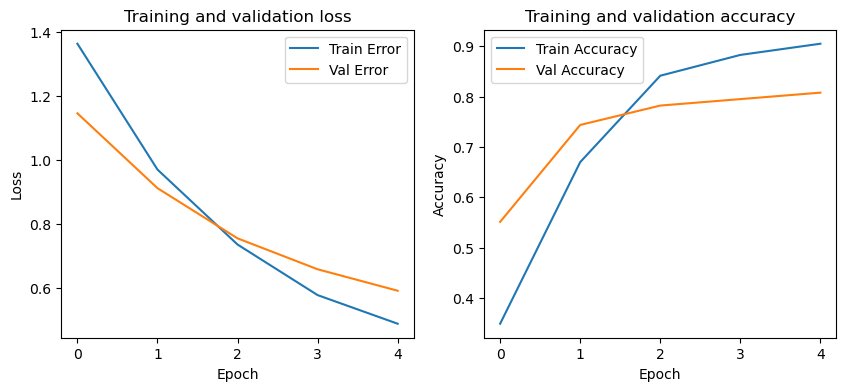

In [30]:
plot_history(history_0)